In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r'C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\Bago_Bago_pv_weather_merged.csv')

In [3]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [4]:
columns=['electricity','sunshine_duration (s)', 'shortwave_radiation (W/m²)', 'is_day ()', 'temperature_2m (°C)', 'cloud_cover (%)']
for col in columns:
    for lag in range(1,3):
        df[f'{col}_lag_{lag}']=df[col].shift(lag)


In [5]:

df['electricity_future'] = df['electricity'].shift(-1)
df.dropna(inplace=True)

df['electricity'].describe()


count    8781.000000
mean        0.176657
std         0.237202
min         0.000000
25%         0.000000
50%         0.001000
75%         0.355000
max         0.813000
Name: electricity, dtype: float64

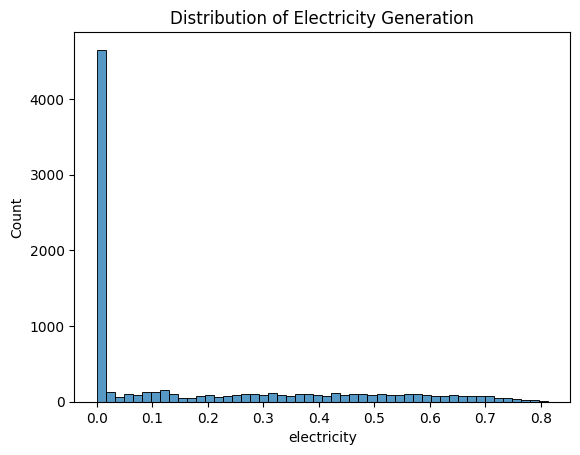

In [6]:
import seaborn as sns

# Plot distribution
sns.histplot(df['electricity'], bins=50)
plt.title("Distribution of Electricity Generation")
plt.show()


In [7]:
df['isw']=df['day'].apply(lambda x: 1 if x <=5 else 0 )

In [8]:

def get_season_myanmar(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [6,7,8,9,10]:
        return 'rainy'
    elif month in [3,4,5]:
        return 'Summer'
 
df['season'] = df['month'].apply(get_season_myanmar)


df['season'].value_counts()


season
rainy     3672
Winter    2901
Summer    2208
Name: count, dtype: int64

In [9]:
df.head()

,electricity,date,time,year,month,day,latitude,longitude,elevation,utc_offset_seconds,...,shortwave_radiation (W/m²)_lag_2,is_day ()_lag_1,is_day ()_lag_2,temperature_2m (°C)_lag_1,temperature_2m (°C)_lag_2,cloud_cover (%)_lag_1,cloud_cover (%)_lag_2,electricity_future,isw,season
2,0.0,2022-01-01,2:00:00,2022,1,1,17.328646,96.50289,13,0,...,0.0,1.0,0.0,22.8,21.1,9.0,20.0,0.000,1,Winter
3,0.0,2022-01-01,3:00:00,2022,1,1,17.328646,96.50289,13,0,...,46.0,1.0,1.0,24.7,22.8,0.0,9.0,0.000,1,Winter
4,0.0,2022-01-01,4:00:00,2022,1,1,17.328646,96.50289,13,0,...,225.0,1.0,1.0,26.7,24.7,26.0,0.0,0.000,1,Winter
5,0.0,2022-01-01,5:00:00,2022,1,1,17.328646,96.50289,13,0,...,429.0,1.0,1.0,28.3,26.7,30.0,26.0,0.000,1,Winter
6,0.0,2022-01-01,6:00:00,2022,1,1,17.328646,96.50289,13,0,...,570.0,1.0,1.0,29.3,28.3,12.0,30.0,0.032,1,Winter


In [10]:
df = pd.get_dummies(df, columns=['season'], drop_first=False)
for col in df.columns:
    if 'season_' in col:
        df[col]=df[col].astype('int')

In [11]:
df.head()

,electricity,date,time,year,month,day,latitude,longitude,elevation,utc_offset_seconds,...,is_day ()_lag_2,temperature_2m (°C)_lag_1,temperature_2m (°C)_lag_2,cloud_cover (%)_lag_1,cloud_cover (%)_lag_2,electricity_future,isw,season_Summer,season_Winter,season_rainy
2,0.0,2022-01-01,2:00:00,2022,1,1,17.328646,96.50289,13,0,...,0.0,22.8,21.1,9.0,20.0,0.000,1,0,1,0
3,0.0,2022-01-01,3:00:00,2022,1,1,17.328646,96.50289,13,0,...,1.0,24.7,22.8,0.0,9.0,0.000,1,0,1,0
4,0.0,2022-01-01,4:00:00,2022,1,1,17.328646,96.50289,13,0,...,1.0,26.7,24.7,26.0,0.0,0.000,1,0,1,0
5,0.0,2022-01-01,5:00:00,2022,1,1,17.328646,96.50289,13,0,...,1.0,28.3,26.7,30.0,26.0,0.000,1,0,1,0
6,0.0,2022-01-01,6:00:00,2022,1,1,17.328646,96.50289,13,0,...,1.0,29.3,28.3,12.0,30.0,0.032,1,0,1,0


In [12]:
df_oot=df[df['month'].isin([9,10,11])]
df=df[~df.index.isin(df_oot.index)]

In [13]:
columns_list = df.columns.tolist()
print(columns_list)


['electricity', 'date', 'time', 'year', 'month', 'day', 'latitude', 'longitude', 'elevation', 'utc_offset_seconds', 'timezone', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'precipitation (mm)', 'weather_code (wmo code)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()', 'sunshine_duration (s)', 'shortwave_radiation (W/m²)', 'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)', 'global_tilted_irradiance (W/m²)', 'electricity_lag_1', 'electricity_lag_2', 'sunshine_duration (s)_lag_1', 'sunshine_duration (s)_lag_2', 'shortwave_radiation (W/m²)_lag_1', 'shortwave_radiation (W/m²)_lag_2', 'is_day ()_lag_1', 'is_day ()_lag_2', 'temperature_2m (°C)_lag_1', 'temperature_2m (°C)_lag_2', 'cloud_cover (%)_lag_1', 'cloud_cover (%)_lag_2', 'electricity_future', 'isw', 'season_Summer', 'season_Winter', 'season_rainy']


In [20]:
X = df[['electricity','sunshine_duration (s)', 'shortwave_radiation (W/m²)', 'is_day ()', 'temperature_2m (°C)', 'cloud_cover (%)',  'electricity_lag_1', 'electricity_lag_2', 'sunshine_duration (s)_lag_1', 'sunshine_duration (s)_lag_2', 'shortwave_radiation (W/m²)_lag_1', 'shortwave_radiation (W/m²)_lag_2', 'is_day ()_lag_1', 'is_day ()_lag_2', 'temperature_2m (°C)_lag_1', 'temperature_2m (°C)_lag_2', 'cloud_cover (%)_lag_1', 'cloud_cover (%)_lag_2', 'season_Summer', 'season_Winter', 'season_rainy','isw']]
y = df['electricity_future']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

# # Initialize the XGBoost model
# xgb_model = xgb.XGBRegressor()

# # Define the parameter grid with ranges to explore
# param_grid = {
#     'n_estimators': [50, 100, 200],            # Number of boosted trees
#     'subsample': [0.6, 0.8, 1],               # Fraction of the training set used to grow trees
#     'learning_rate': [0.01, 0.05, 0.1],       # Step size shrinkage
#     'max_depth': [2, 3, 6],                   # Maximum tree depth for base learners
#     'colsample_bytree': [0.6, 0.8, 1],        # Subsample ratio of columns when constructing each tree
#     'min_child_weight': [1, 2, 5]             # Minimum sum of instance weight (hessian) needed in a child
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=param_grid, 
#                            scoring='neg_mean_squared_error',  # Use MSE for regression evaluation
#                            cv=3,                              # Cross-validation folds
#                            verbose=1,                         # Show progress
#                            n_jobs=-1)                         # Use all available cores

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters found by the grid search
# print("Best parameters found: ", grid_search.best_params_)
# print("Best RMSE score from Grid Search: ", (-grid_search.best_score_)**0.5)


In [21]:


# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200,subsample=1, learning_rate=0.05,max_depth=2,colsample_bytree=1,min_child_weight=5)

# Train the model
xgb_model.fit(X_train, y_train)

# # Make predictions on the test set
y_pred = xgb_model.predict(X_test)

Mean Squared Error: 0.0008611435664331612
Root Mean Squared Error: 0.029345247765748397


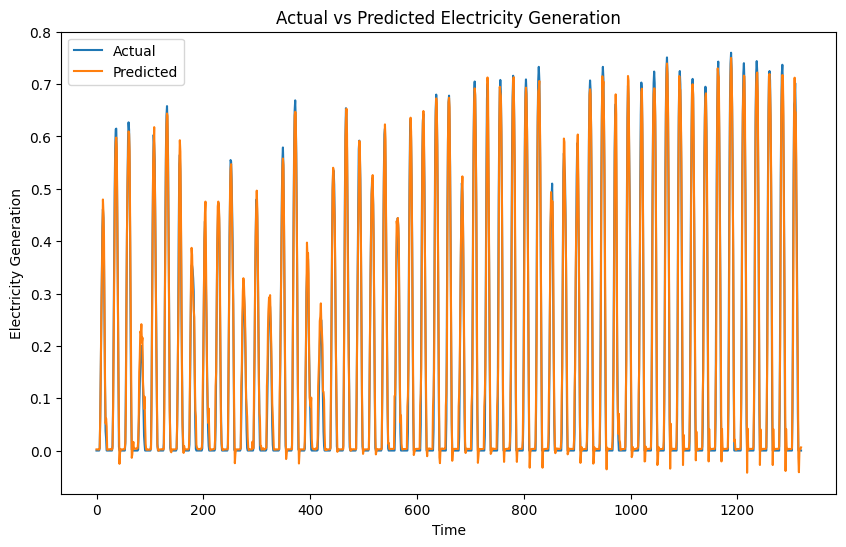

In [22]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Electricity Generation')
plt.xlabel('Time')
plt.ylabel('Electricity Generation')
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have your actual and predicted values from the regression model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 0.0008611435664331612
Root Mean Squared Error (RMSE): 0.029345247765748397
Mean Absolute Error (MAE): 0.01833806508890967
R² Score: 0.9847566186177357


In [24]:

X_oot = df_oot[X_train.columns]

# Make predictions on the OOT set
y_pred_oot = xgb_model.predict(X_oot)

# Output the predictions
print(y_pred_oot)

y_actual_oot = df_oot['electricity_future']  # Actual target values for comparison
mse_oot = mean_squared_error(y_actual_oot, y_pred_oot)
rmse_oot = mse_oot**0.5
r2 = r2_score(y_actual_oot, y_pred_oot)
print(f'MSE on OOT: {mse_oot}')
print(f'RMSE on OOT: {rmse_oot}')
print(r2)


[-0.00654629  0.00143502  0.00222982 ...  0.1243402   0.06081382
  0.06737425]
MSE on OOT: 0.0007691588191616219
RMSE on OOT: 0.027733712682611066
0.9863696414374201


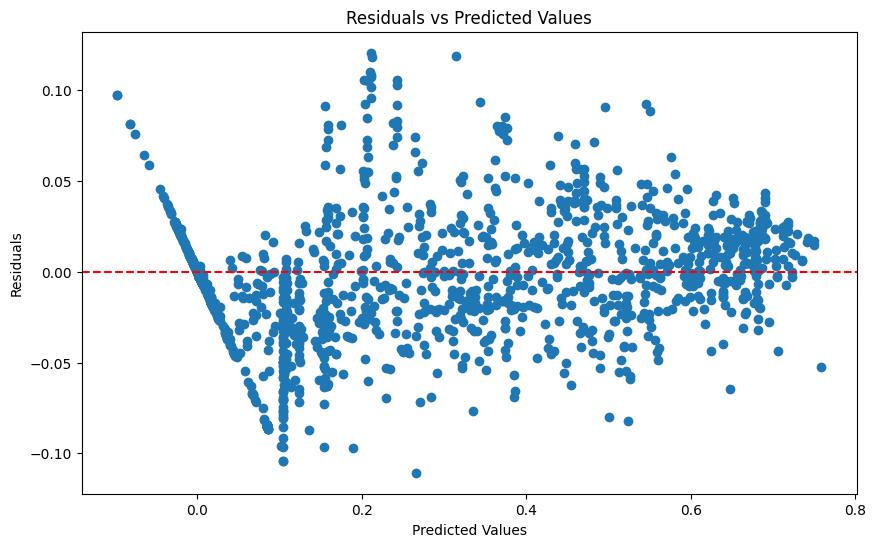

In [25]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = df_oot['electricity_future'] - y_pred_oot

# Plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred_oot, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


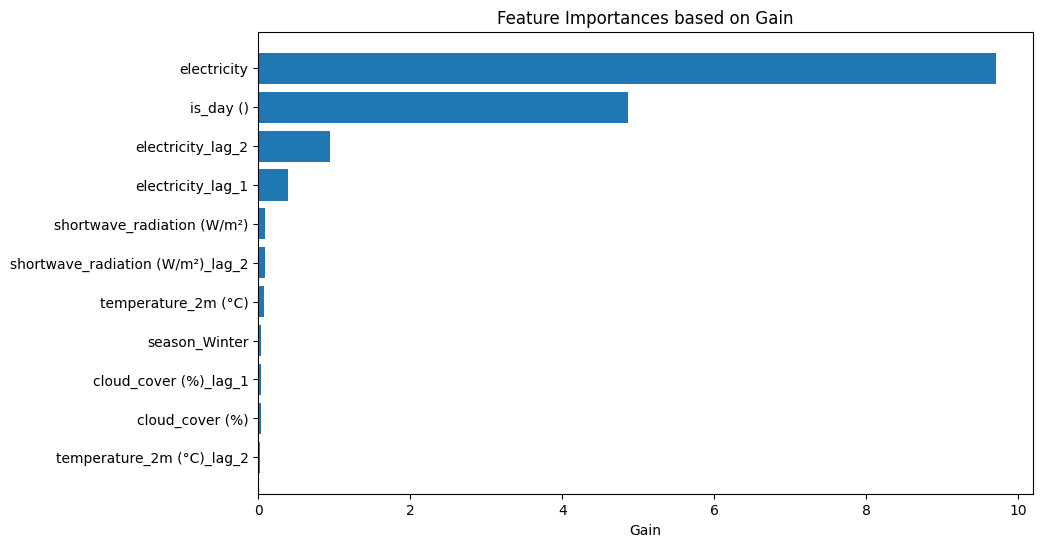

                             Feature      Gain
0                        electricity  9.708620
2                          is_day ()  4.857665
6                  electricity_lag_2  0.942453
5                  electricity_lag_1  0.397379
1         shortwave_radiation (W/m²)  0.088772
7   shortwave_radiation (W/m²)_lag_2  0.083439
3                temperature_2m (°C)  0.073283
10                     season_Winter  0.039262
9              cloud_cover (%)_lag_1  0.034396
4                    cloud_cover (%)  0.031824
8          temperature_2m (°C)_lag_2  0.021490


In [26]:
# Plot the feature importance based on gain
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model is your trained XGBoost model
# Get the feature importances based on 'gain'
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

# Convert it into a sorted DataFrame for better visualization
import pandas as pd
importance_df = pd.DataFrame(
    feature_importance.items(), columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'])
plt.xlabel("Gain")
plt.title("Feature Importances based on Gain")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

# Print the sorted feature importance
print(importance_df)


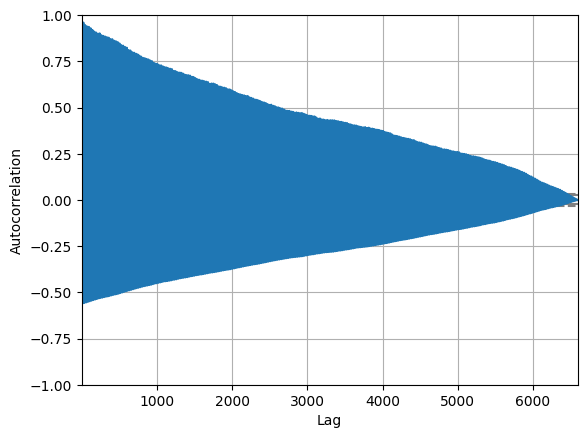

In [94]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['electricity'])
plt.show()


c:\Users\Nino\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


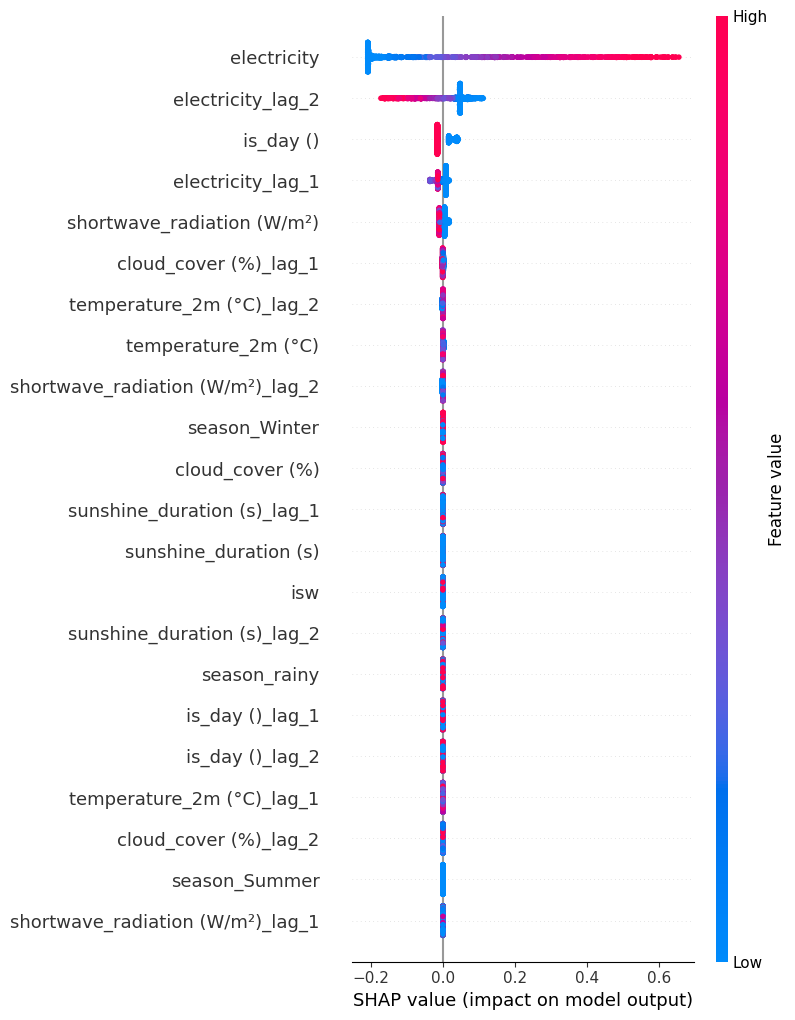

In [27]:
import shap

# Initialize SHAP explainer for your XGBoost model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the test dataset
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])


In [29]:
import csv
import os


# Model evaluation metrics
mse = mean_squared_error(y_actual_oot, y_pred_oot)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual_oot, y_pred_oot)
r2 = r2_score(y_actual_oot, y_pred_oot)


features_used = list(X_train.columns)

# CSV file to store the results
csv_file = 'model_results.csv'

# Check if the file exists
file_exists = os.path.isfile(csv_file)

# Open the CSV file and append results
with open(csv_file, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'n_estimators', 'subsample', 'learning_rate', 'max_depth', 
        'colsample_bytree', 'min_child_weight', 'mse', 'rmse', 'mae', 'r2', 'features'
    ])
    
    # Write the header if the file does not exist
    if not file_exists:
        writer.writeheader()
    
    # Write the model results to the CSV
    writer.writerow({
        'n_estimators': xgb_model.get_params()['n_estimators'],
        'subsample': xgb_model.get_params()['subsample'],
        'learning_rate': xgb_model.get_params()['learning_rate'],
        'max_depth': xgb_model.get_params()['max_depth'],
        'colsample_bytree': xgb_model.get_params()['colsample_bytree'],
        'min_child_weight': xgb_model.get_params()['min_child_weight'],
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'features': ', '.join(features_used)  # Save features as a comma-separated string
    })

print("Model details and metrics saved successfully.")



Model details and metrics saved successfully.


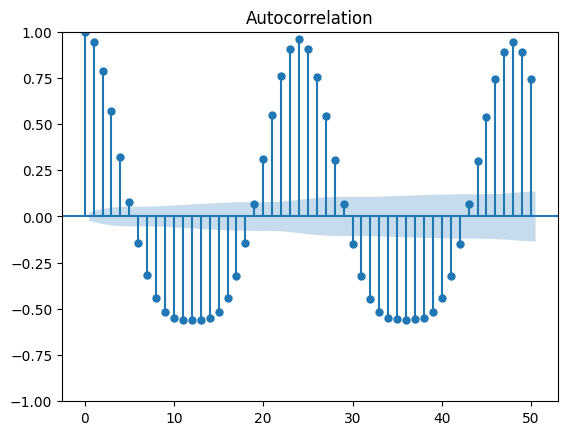

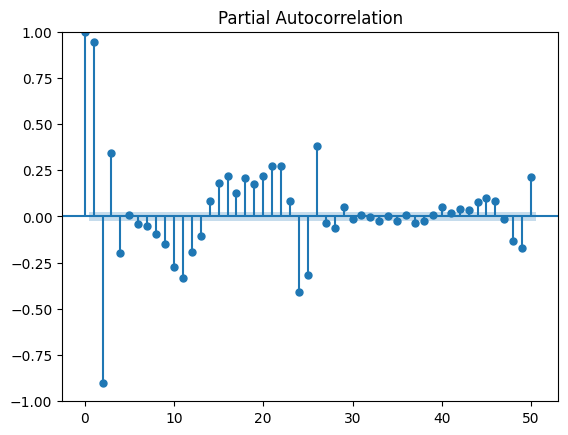

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for electricity
plot_acf(df['electricity'], lags=50)
plt.show()

plot_pacf(df['electricity'], lags=50)
plt.show()
